Let's start playing for the first time with music files.

Thanks to Parul Pandey's blog post : https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
import librosa 
import librosa.display
import IPython.display as ipd

In [3]:
import seaborn as sns
sns.set()

In [4]:
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

### Path and load

In [41]:
audio_path = './data/darbuka/rythms/baladi_loop.wav'
#audio_path = './data/songs/ta_boom.mp3'
x , sr = librosa.load(audio_path, sr=None)

In [29]:
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(9396828,) 44100


#### Play !

In [46]:
ipd.Audio(audio_path)

#### Plot of the amplitude envelope of the audio array

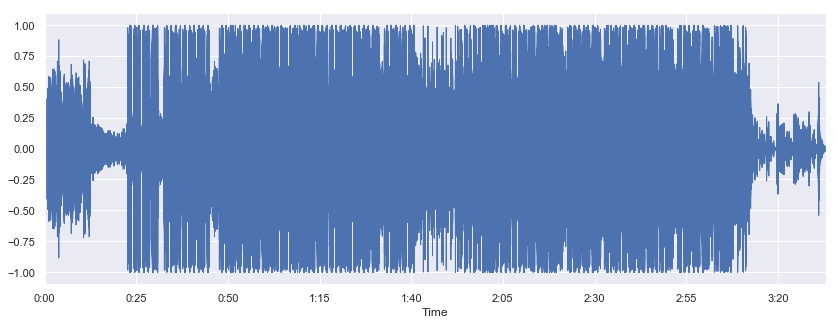

In [31]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

#### Spectrogram

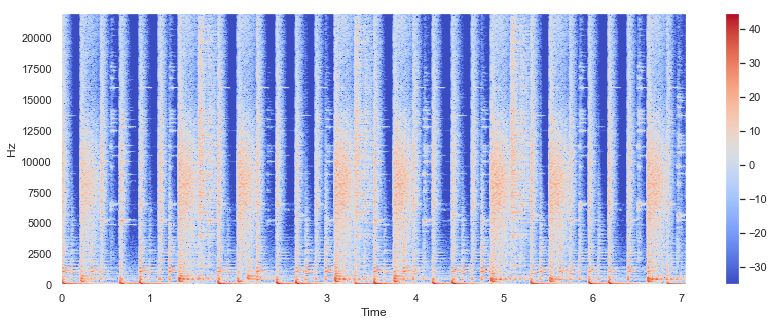

In [20]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

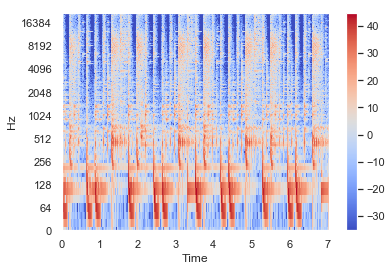

In [21]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

### Feature extraction
zoom

3
[ 0.37142944  0.40551758  0.20742798  0.36486816  0.5220337   0.5204315
  0.39717102  0.2740631   0.37469482  0.3710785   0.5109558   0.45147705
  0.21369934  0.3071289   0.33613586  0.39234924  0.5516052   0.3313141
  0.22402954  0.27468872  0.3483429   0.399292    0.4643402   0.6038513
  0.4434662   0.31697083  0.30099487  0.3344574   0.46540833  0.50227356
  0.4980774   0.25372314  0.17825317  0.21121216  0.11999512  0.29542542
  0.37608337  0.27589417  0.06216431  0.00775146  0.03694153  0.03456116
  0.06474304 -0.02153015 -0.07092285  0.17884827  0.1857605   0.03451538
 -0.17173767 -0.07077026]


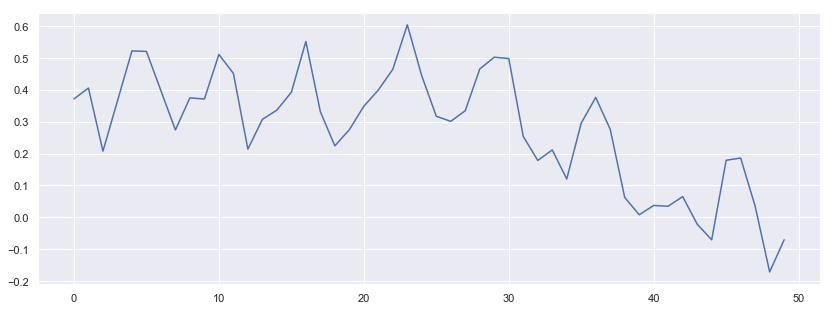

In [22]:
n0 = 1000
n1 = 1050
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])

zero_crossings = librosa.zero_crossings(x[n0:n1], pad=False)
print(sum(zero_crossings))
print(x[n0:n1])

#### Spectral centroid

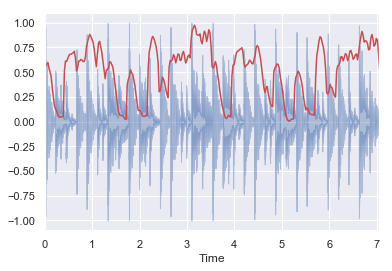

In [23]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape
(775,)
# Computing the time variable for visualization
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

#### Chroma frequency

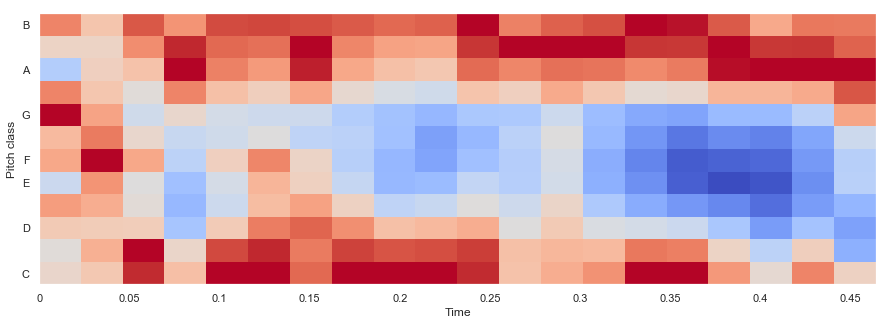

In [24]:
n0 = 0
n1 = 10000
hop_length = 512
chromagram = librosa.feature.chroma_stft(x[n0:n1], sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')

#### Separate percus - hamonics

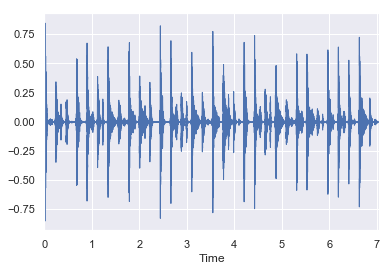

In [48]:
percus = librosa.effects.percussive(x, margin=3.0)
librosa.display.waveplot(percus,sr)

In [49]:
ipd.Audio(percus, rate=sr)

In [47]:
harmonics = librosa.effects.harmonic(x, margin=3.0)
ipd.Audio(harmonics, rate=sr)

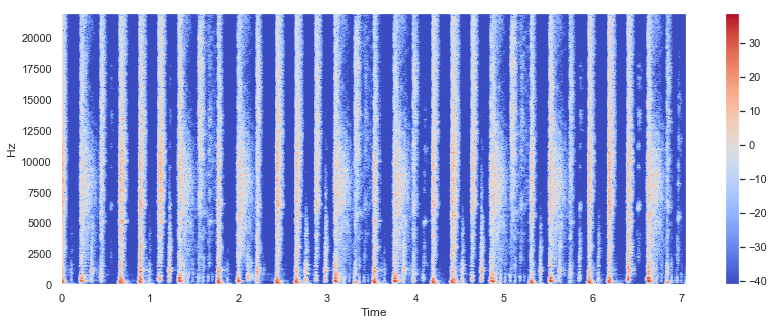

In [45]:
X = librosa.stft(percus)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

#### Extract the beat

In [67]:
tempo, beats = librosa.beat.beat_track(y=percus, sr=sr)
print(librosa.frames_to_time(beats[:20], sr=sr))

[0.46439909 0.89396825 1.33514739 1.77632653 2.22911565 2.65868481
 3.09986395 3.54104308 3.9938322  4.42340136 4.8645805  5.31736961
 5.75854875 6.18811791]


(-1, 1)

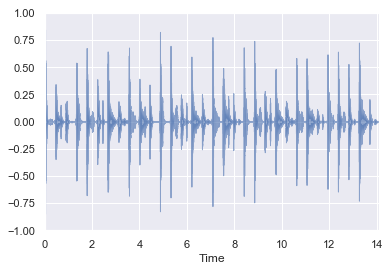

In [70]:
onset_env = librosa.onset.onset_strength(percus, sr=sr,
                                         aggregate=np.median)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,
                                    sr=sr)
tempo
librosa.display.waveplot(percus, alpha=0.6)
plt.vlines(beats, -1, 1, color='r')
plt.ylim(-1, 1)

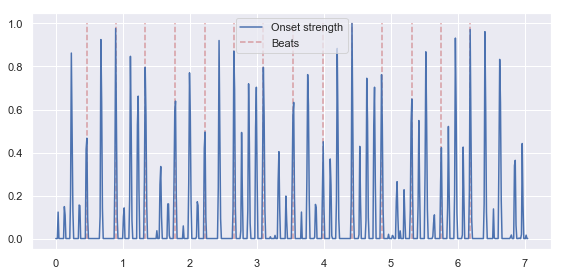

In [66]:
hop_length = 512
plt.figure(figsize=(8, 4))
times = librosa.frames_to_time(np.arange(len(onset_env)),
                               sr=sr, hop_length=hop_length)
plt.plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
plt.vlines(times[beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats')
plt.legend(frameon=True, framealpha=0.75)

plt.gca().xaxis.set_major_formatter(librosa.display.TimeFormatter())
plt.tight_layout()

#### Tempo

In [52]:
hop_length = 512
oenv = librosa.onset.onset_strength(y=x, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                       hop_length=hop_length)

ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                          hop_length=hop_length)[0]

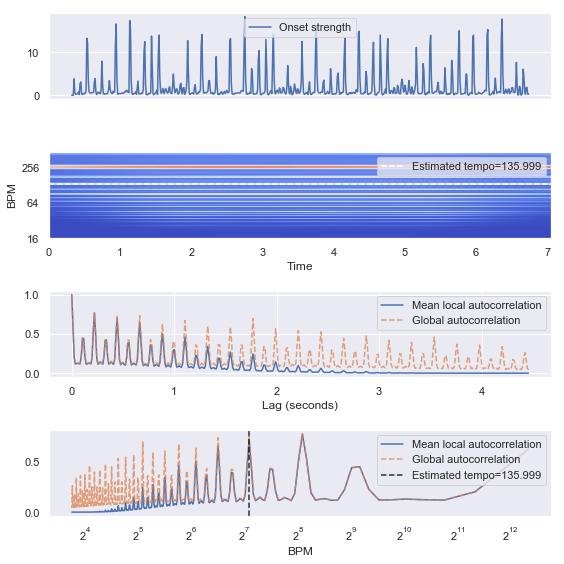

In [53]:
plt.figure(figsize=(8, 8))
plt.subplot(4, 1, 1)
plt.plot(oenv, label='Onset strength')
plt.xticks([])
plt.legend(frameon=True)
plt.axis('tight')
plt.subplot(4, 1, 2)
# We'll truncate the display to a narrower range of tempi
librosa.display.specshow(tempogram, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='tempo')
plt.axhline(tempo, color='w', linestyle='--', alpha=1,
            label='Estimated tempo={:g}'.format(tempo))
plt.legend(frameon=True, framealpha=0.75)
plt.subplot(4, 1, 3)
x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr,
                num=tempogram.shape[0])
plt.plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
plt.plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
plt.xlabel('Lag (seconds)')
plt.axis('tight')
plt.legend(frameon=True)
plt.subplot(4,1,4)
# We can also plot on a BPM axis
freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
plt.semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),
             label='Mean local autocorrelation', basex=2)
plt.semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,
             label='Global autocorrelation', basex=2)
plt.axvline(tempo, color='black', linestyle='--', alpha=.8,
             label='Estimated tempo={:g}'.format(tempo))
plt.legend(frameon=True)
plt.xlabel('BPM')
plt.axis('tight')
plt.grid()
plt.tight_layout()

ValueError: Array audio input must be a 1D or 2D array